# Paper Section: Fig 1 in Results

Following these analysis, we observe that a good fit requires at least a few data points at the linear range. Thus, the worklfow for generating learning curves can be as follows. That is particularly efficient sequential processing.
1. Start with the largest training subset, and proceed to smaller subsets with a pre-defined step size.
2. Generate at least 4 learning curve points and fit power-law. Record RMSE (goodness-of-fit).
3. Starting from the 5th point (that's a heuristic), fit a power-law to the existing learning curve points. If the fit does not improve, as measured by RMSE, we terminate the workflow.

Notes:<br>
We evaluate the quality (usefulness) of fit with two measures:
1. RMSE
2. Ability to extrapolate

Question:
1. Why plots generated by LGBM and RF are so consistent across runs?? Is it because we use the same random_state??

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from glob import glob

import matplotlib
import matplotlib.pyplot as plt

# Make all python scripts available in the path
sys.path.append('../')

import pp_utils
import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

/vol/ml/apartin/projects/LearningCurves/notebooks


In [2]:
save_fig_path = filepath/'figs'

In [3]:
def save_fig(save_fig_path, fname):    
    plt.savefig(save_fig_path/(fname + '.eps'), format='eps')
    plt.savefig(save_fig_path/(fname + '.png'))

### Get dir path of all runs

In [4]:
# src = 'gdsc_on_cell'
src = 'gdsc_on_none'  # Good dataset to show basic stuff!

# src = 'top6_on_cell'
# src = 'top6_on_none'

# GDSC
if src=='gdsc_on_cell':
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_rf_100_trees')

if src=='gdsc_on_none':
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/multi_seed_rf_100_trees')
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/fine_grain_lgb_subset')
    
# Top6    
elif src=='top6_on_cell':
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_cell/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_cell/multi_seed_rf_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_cell/nn_reg_ap')
    
elif src=='top6_on_none':
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/multi_seed_rf_100_trees')

"""
elif src=='ctrp':
    pass
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_lgbm_100_trees_no_hpo')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_rf_100_trees_no_hpo')    
    
elif src=='top21':    
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top21/split_on_cell/multi_seed_lgbm_100_trees')
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top21/split_on_cell/multi_seed_rf_100_trees')
"""    
    
# Get all run dirs
runs = glob(str(base_dir/'*'))

### Aggregate results over runs

In [6]:
scores = []
for i, r in enumerate(runs):
    # scr_tmp = pd.read_csv( Path(r)/'lrn_crv_scores.csv' )
    dpath = Path(r)/'lrn_crv_scores.csv'
    if not dpath.exists(): continue
        
    scr_tmp = pd.read_csv( dpath )
    scr_tmp.rename(columns={'fold0': 'run'+str(i+1)}, inplace=True)
    if len(scores)==0:
        scores = scr_tmp
    else:
        scores = scores.merge(scr_tmp, on=['metric', 'tr_size', 'set'])
        
run_col_names = [c for c in scores.columns if 'run' in c]

scores_mean   = scores[run_col_names].mean(axis=1)
scores_median = scores[run_col_names].median(axis=1)
scores_std    = scores[run_col_names].std(axis=1)

scores.insert(loc=3, column='mean', value=scores_mean)
scores.insert(loc=3, column='median', value=scores_median)
scores.insert(loc=3, column='std', value=scores_std)
print(len(np.unique(scores.tr_size)))

display(scores[:2])
print('Training set sizes:', np.unique(scores.tr_size))

save = True
if save:
    scores.to_csv(base_dir/'all_seed_runs_scores.csv', index=False)

93


,Unnamed: 0_x,metric,tr_size,std,median,mean,set,run1,Unnamed: 0_y,run2,...,Unnamed: 0_y,run5,Unnamed: 0_x,run6,Unnamed: 0_y,run7,Unnamed: 0_x,run8,Unnamed: 0_y,run9
0,0,mean_absolute_error,2,0.073099,0.039725,0.073975,tr,0.03565,0,0.188850,...,0,0.006750,0,0.02570,0,0.140400,0,0.043800,0,0.148000
1,1,mean_absolute_error,8,0.035035,0.102738,0.119389,tr,0.10680,1,0.094494,...,1,0.096544,1,0.08075,1,0.098675,1,0.171991,1,0.139644


Training set sizes: [    2     8    14    21    27    33    40    46    52    59    65    71
    78    84    90    97   103   109   116   122   129   135   141   148
   154   160   167   173   179   186   192   198   205   211   217   224
   230   236   243   249   256   300   702  1104  1506  1908  2310  2712
  3114  3516  3918  4321  4723  5125  5527  5929  6331  6733  7135  7537
  7939  8342  8744  9146  9548  9950 10352 10754 11156 11558 11960 12363
 12765 13167 13569 13971 14373 14775 15177 15579 15981 16384 32768 38291
 43814 49337 54860 60384 65907 71430 76953 82476 88000]


In [7]:
scores_te = scores[(scores.metric=='mean_absolute_error') & (scores.set=='te')].reset_index(drop=True).iloc[:, :6]
scores_te.to_csv(base_dir/'scores.csv', index=False)

# Fig 1a LC on lin-lin scale
Generated using GBDT for multiple data shuffles of GDSC.

In [114]:
figsize = (6, 4.5)
metric_name = 'mean_absolute_error'
tr_set = 'te'

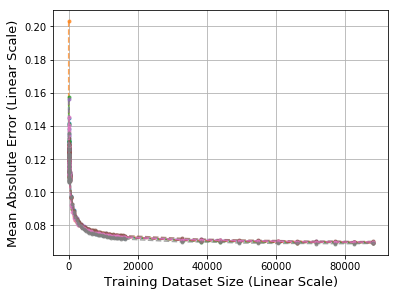

In [115]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'linear', 'ytick_scale': 'linear'}
shard_min_idx=0
# shard_min_idx=1

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shard_min_idx, **plot_args );
plt.savefig(save_fig_path/f'{src}_all_runs_linlin_scale.png')

# Fig 1b LC on log-log scale
Generated using GBDT for multiple data shuffles of GDSC.

- When data is presented on log-log scale, it is easier to discriminate between the different regions of model improvement.

Other comments:<br>
- Certain shuffles generate data that does not result in a successful power law fit when all points are used.
- As a result, we generate data for multiple seeds and aggregate across runs via median.
- Then, we fit a power law to the aggregated LC data.

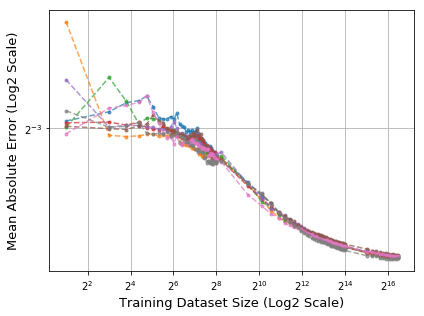

In [116]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'log2', 'ytick_scale': 'log2'}
shard_min_idx=0
# shard_min_idx=1

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shard_min_idx, **plot_args );
plt.tight_layout()
plt.savefig(save_fig_path/f'{src}_all_runs_loglog_scale.png')

In [117]:
# plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'log2', 'ytick_scale': 'log2'}
# shard_min_idx=0
# # shard_min_idx=1

# ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shard_min_idx, **plot_args );
# plt.tight_layout()
# plt.savefig(save_fig_path/f'{src}_all_runs_loglog_scale.png')

# Fig 1c LC of Median and STD across all shuffles

- STD of scores across runs is inversely proportional to the subset size. This can be attributed to the distribution similarity of target values between training subset and test set. The target values, is our use case, are the dose-independent values. The smaller the subset, the lower the similarity with a test set, and therefore, we observe larger variance of scores across runs [shuffles/experiments] at smaller subsets.
- We exploit this observation for ... [Mukherjee exploits this observation ...]

In [118]:
figsize = (6, 4.5)
# figsize = (10, 8)
metric_name = 'mean_absolute_error'
xtick_scale, ytick_scale = 'log2', 'log2'

plot_args = {'metric_name': metric_name, 'xtick_scale': xtick_scale, 'ytick_scale': xtick_scale, 'figsize': figsize}

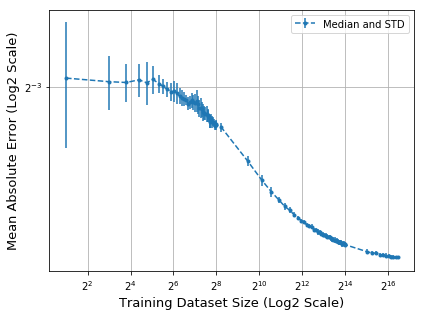

In [119]:
scores_te = scores[ (scores['metric']==metric_name) & (scores['set']=='te') ].reset_index(drop=True)

shard_min_idx=0
# shard_min_idx=1

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][shard_min_idx:], y=scores_te['median'][shard_min_idx:], yerr=scores_te['std'][shard_min_idx:],
        ax=ax, ls='--', marker='.', alpha=1,
        **plot_args, label='Median and STD')

ax.legend(frameon=True, fontsize=10, loc='best');
plt.tight_layout()
plt.savefig(save_fig_path/f'{src}_agg_median_std.png')

# Fig 2a Power-law fit to all LC data

try
GOF: {'rmse': 0.003522654685387257, 'mae': 0.0029500261457625194}


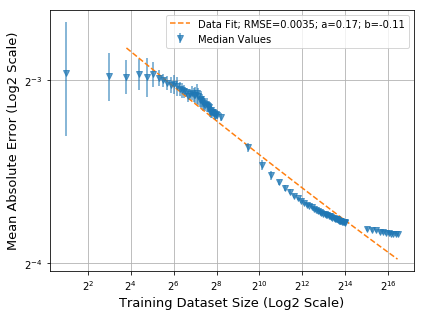

In [120]:
ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][0:], y=scores_te['median'][0:], yerr=scores_te['std'][0:],
        ax=ax, ls='', marker='v', alpha=0.7,
        **plot_args, label='Median Values')

# shard_min_idx = 0
shard_min_idx = 2
ax, _, gof = lrn_crv_plot.plot_lrn_crv_power_law(
        x=scores_te['tr_size'][shard_min_idx:], y=scores_te['median'][shard_min_idx:],
        **plot_args, plot_raw=False, ax=ax, alpha=1);

ax.legend(frameon=True, fontsize=10, loc='best')
plt.tight_layout()
plt.savefig(save_fig_path/f'{src}_agg_median_std_fit_all_points.png')

print('GOF:', gof)

# Fig 2b Power-law fit to a subset all LC data

- The fit improves (smaller RMSE) by exclusing some of the initial points.
- We also observe that better fits result in better agreement with the theoretical values of the power-fit. Specifically, the value of beta.

try
GOF: {'rmse': 0.0002281235509261716, 'mae': 0.00020814484344613103}


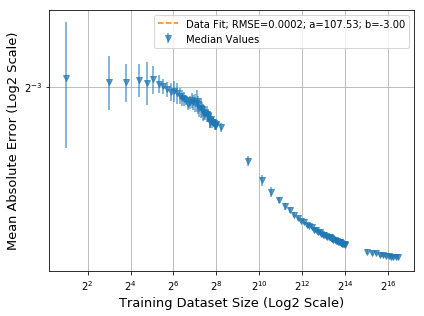

In [121]:
tot_pnts = len(scores_te['tr_size'])
n_pnts_fit = 8 # Number of points to use for curve fitting starting from the largest size

y_col_name = 'median'

ax = None

ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][0:], y=scores_te[y_col_name][0:], yerr=scores_te['std'][0:],
        ax=ax, ls='', marker='v', alpha=0.7,
        **plot_args, label='Median Values')

shard_min_idx = 0 if tot_pnts < n_pnts_fit else tot_pnts - n_pnts_fit

ax, _, gof = lrn_crv_plot.plot_lrn_crv_power_law(
        x=scores_te['tr_size'][shard_min_idx:], y=scores_te[y_col_name][shard_min_idx:],
        **plot_args, plot_raw=False, ax=ax, alpha=1 );

ax.legend(frameon=True, fontsize=10, loc='best')
plt.tight_layout()
plt.savefig(save_fig_path/f'{src}_agg_median_std_fit_subset_points.png')

print('GOF:', gof)

### Fig 2c MAE as a function of LC points

The workflow is to go backwards. We fit a power-law after every time we compute score for consecutive (smaller) shard. Stop when quality of fit decreases.

tot_pnts 17


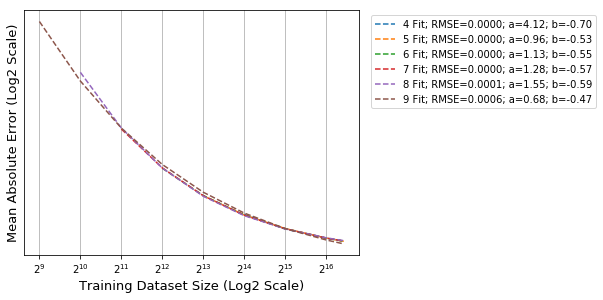

In [45]:
tot_pnts = len(scores_te['tr_size'])
print('tot_pnts', tot_pnts)
# min_points = 3 # 3 points doesn't work
min_pnts_fit = 4
max_pnts_fit = 9
# max_pnts_fit = tot_pnts

p_arr = []
# rmse_arr = []
gof_arr = []
prm_arr = []
ax = None
for n_pnts_fit in range(min_pnts_fit, max_pnts_fit+1):
# for shard_min_idx in range(tot_points - min_points + 1):
    # n_points = tot_points - shard_min_idx
    shard_min_idx = tot_pnts - n_pnts_fit
    
    ax, prm, gof = lrn_crv_plot.plot_lrn_crv_power_law(
            x=scores_te['tr_size'][shard_min_idx:], y=scores_te['median'][shard_min_idx:],
            **plot_args, ax=ax, plot_raw=False, label=str(n_pnts_fit) );
    
    prm_arr.append(prm)
    gof_arr.append(gof)
    p_arr.append(n_pnts_fit)
    
# ax.legend(frameon=True, fontsize=10, loc='best');

# idx = np.array(rmse_arr).argmin()
# p_arr[idx]

In [46]:
prm_df = pd.DataFrame(prm_arr)
gof_df = pd.DataFrame(gof_arr)
n_pnts_df = pd.DataFrame({'n_pnts': p_arr})
dd = pd.concat([n_pnts_df, gof_df, prm_df], axis=1)

display(dd.sort_values('mae'))

,n_pnts,mae,rmse,alpha,beta,gamma
0,4,1.081598e-07,1.264139e-07,4.124380,-0.697927,0.068243
3,7,3.483427e-05,4.461233e-05,1.276733,-0.568142,0.067716
2,6,3.517281e-05,4.192842e-05,1.129097,-0.552468,0.067587
1,5,3.783036e-05,4.341685e-05,0.956741,-0.532353,0.067441
4,8,6.352144e-05,7.953847e-05,1.547220,-0.594106,0.067959
5,9,4.435710e-04,5.984622e-04,0.676031,-0.472859,0.066259


The plot below can go to a table!

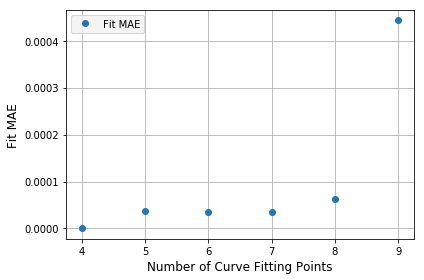

In [47]:
plot_beta = False

fig, ax1 = plt.subplots()

# Plot metrics
alpha = 0.6
linewidth = 1
fontsize = 12
lns1 = ax1.plot(dd.n_pnts, dd.mae, marker='o', ls='', label='Fit MAE');
ax1.set_xlabel('Number of Curve Fitting Points', fontsize=fontsize)
ax1.set_ylabel('Fit MAE', fontsize=fontsize)
ax1.tick_params('y', colors='k')

leg = lns1

if plot_beta:
    ax2 = ax1.twinx()
    lns2 = ax2.plot(dd.n_pnts, dd.beta, color='m', marker='*', ls='', label='Fit Parameter $b$')
    ax2.set_ylabel('Fit Parameter $b$ in $am^{b} + c$', color='k', fontsize=fontsize)
    ax2.tick_params('y', colors='k')
    leg.append(lns2)
        
ax1.grid(True)

# leg = lns1 + lns2
labs = [l.get_label() for l in leg]
legend = ax1.legend(leg, labs, loc=0)
frame = legend.get_frame()
frame.set_facecolor('0.95')
plt.tight_layout()

plt.savefig(save_fig_path/f'{src}_mae_prm_b_num_points.png')

# Fig 3a Extrapolate

fit_min_id=0, m=129
fit_max_id=22, m=702
ext=22, m=4723
Extrapolation MAE 0.00016695018571463716


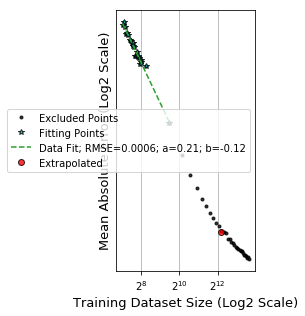

In [222]:
scr = scores_te.copy()
# scr = scores_te.copy().reset_index(drop=True)
# scr = scores_te.copy().iloc[5:, :].reset_index(drop=True)
# shift = 20
scr = scores_te.copy().iloc[20:-20, :].reset_index(drop=True)
# plot_args['figsize'] = (11, 8)
plot_args['figsize'] = (6, 4.5)
tot_pnts = len(scr['tr_size'])
# fit_min = 20  # good start
# fit_max = 42  # good end

fit_min = 20-20  # good start
fit_max = 42-20  # good end

y_col_name = 'median'
# plot_args['xtick_scale'], plot_args['ytick_scale'] = 'linear', 'linear'
plot_args['xtick_scale'], plot_args['ytick_scale'] = 'log2', 'log2'

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
        x = scr['tr_size'], y = scr[y_col_name], # yerr = scr['std'],
        ax=ax, ls='', marker='.', alpha=0.8, color='k',
        **plot_args, label='Excluded Points')

ax = lrn_crv_plot.plot_lrn_crv_new(
        x = scr.loc[fit_min:fit_max, 'tr_size'], y = scr.loc[fit_min:fit_max, y_col_name], # yerr = scr.loc[fit_min:fit_max, 'std'],
        ax=ax, ls='', marker='*', alpha=0.8, color='c',
        **plot_args, label='Fitting Points')

ax, fit_prms, gof = lrn_crv_plot.plot_lrn_crv_power_law(
        x=scr.loc[fit_min:fit_max, 'tr_size'], y=scr.loc[fit_min:fit_max, y_col_name],
        **plot_args, plot_raw=False, ax=ax, alpha=1 );

print('fit_min_id={}, m={}'.format(fit_min, scr.loc[fit_min, 'tr_size']))
print('fit_max_id={}, m={}'.format(fit_max, scr.loc[fit_max, 'tr_size']))
x_ext = 52-20  # good extrapolation -->
# x_ext = 70-20  # bad extrapolation -->
# x_ext = 57
print('ext={}, m={}'.format(fit_max, scr.loc[x_ext, 'tr_size']))
y_ext = lrn_crv_plot.power_law_func_3prm(x=scr.loc[x_ext, 'tr_size'], **fit_prms)

ext_mae = abs(y_ext - scr.loc[x_ext, y_col_name])
print('Extrapolation MAE', ext_mae)

ax = lrn_crv_plot.plot_lrn_crv_new(
        x = np.array(scr.loc[x_ext, 'tr_size']), y = y_ext,
        ax=ax, ls='', marker='o', alpha=0.8, color='r',
        **plot_args, label='Extrapolated')

plt.tight_layout()
ax.legend(frameon=True, fontsize=10, loc='best')
save_fig(save_fig_path, fname=f'{src}_fine_grain_extrap_linling')

fit_min 0
fit_max 11
try
0.07751367459716901
GOF: {'rmse': 0.0019139214244821938, 'mae': 0.0017374584641818337}
Fit MAE: {'mae_it': 3.89836306125708e-05, 'mae_et': 1.2426768422155177e-05}


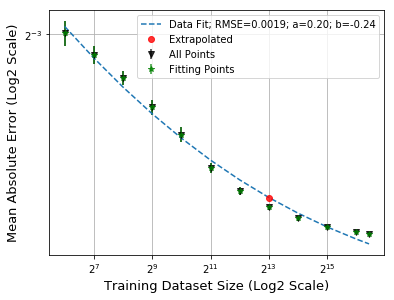

In [110]:
scr = scores_te.copy()
scr = scores_te.copy().iloc[5:, :].reset_index(drop=True)
# plot_args['figsize'] = (10, 8)
plot_args['figsize'] = (6, 4.5)
tot_pnts = len(scr['tr_size'])
fit_min = 0
fit_max = 11
print('fit_min', fit_min)
print('fit_max', fit_max)

# plot_args['xtick_scale'], plot_args['ytick_scale'] = 'linear', 'linear'
# plot_args['xtick_scale'], plot_args['ytick_scale'] = 'log2', 'log2'

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
        x = scr['tr_size'], y = scr['median'], yerr = scr['std'],
        ax=ax, ls='', marker='v', alpha=0.8, color='k',
        **plot_args, label='All Points')

ax = lrn_crv_plot.plot_lrn_crv_new(
        x = scr.loc[fit_min:fit_max, 'tr_size'], y = scr.loc[fit_min:fit_max, 'median'], yerr = scr.loc[fit_min:fit_max, 'std'],
        ax=ax, ls='', marker='*', alpha=0.8, color='g',
        **plot_args, label='Fitting Points')

ax, fit_prms, gof = lrn_crv_plot.plot_lrn_crv_power_law(
        x=scr.loc[fit_min:fit_max, 'tr_size'], y=scr.loc[fit_min:fit_max, y_col_name],
        **plot_args, plot_raw=False, ax=ax, alpha=1 );

xfit = 7
yfit = lrn_crv_plot.power_law_func_3prm(x=scr['tr_size'][xfit], **fit_prms)
print(yfit)

ax = lrn_crv_plot.plot_lrn_crv_new(
        x = scr.loc[xfit, 'tr_size'], y = yfit,
        ax=ax, ls='', marker='o', alpha=0.8, color='r',
        **plot_args, label='Extrapolated')

ax.legend(frameon=True, fontsize=10, loc='best')
plt.savefig(save_fig_path/f'{src}_extrapolate.png')

print('GOF:', gof)
print('Fit MAE:', mae_et)

In [102]:
scr['tr_size']

0        64
1       128
2       256
3       512
4      1024
5      2048
6      4096
7      8192
8     16384
9     32768
10    65536
11    88416
Name: tr_size, dtype: int64

In [85]:
2**7

128

In [ ]:
scr = scores_te.copy()
# scr = scores_te.copy().iloc[:-5, :]

# plot_args['figsize'] = (10, 8)
plot_args['figsize'] = (6, 4.5)

n_pnts_ext = 2 # Number of points to extrapolate to
n_pnts_fit = 6 # Number of points to use for curve fitting starting from the largest size

tot_pnts = len(scr['tr_size'])
m0 = tot_pnts - n_pnts_ext # The adjusted number of available LC points
shard_min_idx = m0 - n_pnts_fit
    
# p_et = 2 # Number of points to extrapolate to
# tot_pnts = len(scr['tr_size'])
# m0 = tot_pnts - p_et

print('tot_pnts', tot_pnts)
# min_points = 3 # 3 points doesn't work
# min_pnts = 4 # min points to use in the fit
# max_pnts = 9
# max_pnts = tot_pnts

# shard_min_idx = 0 if tot_pnts < n_pnts_fit else tot_pnts - n_pnts_fit

# n_pnts = 6 # Number of points to use for curve fitting
# shard_min_idx = tot_pnts - n_pnts
# shard_min_idx = m0 - n_pnts

ax = None

# Plot of all the points
ax = lrn_crv_plot.plot_lrn_crv_new(
        x = scr['tr_size'][0:shard_min_idx], y = scr['median'][0:shard_min_idx], yerr = scr['std'][0:shard_min_idx],
        ax=ax, ls='', marker='v', alpha=0.8, color='k',
        **plot_args, label='Excluded Points')

# Plot of all the points
ax = lrn_crv_plot.plot_lrn_crv_new(
        x = scr['tr_size'][shard_min_idx:m0], y = scr['median'][shard_min_idx:m0], yerr = scr['std'][shard_min_idx:m0],
        ax=ax, ls='', marker='*', alpha=0.8, color='g',
        **plot_args, label='Included Points')

# Extrapolation
ax, _, mae_et = lrn_crv_plot.lrn_crv_power_law_extrapolate(
        x = scr['tr_size'][shard_min_idx:], y = scr['median'][shard_min_idx:],
        n_pnts_ext = n_pnts_ext,
        **plot_args, plot_raw_it=False, label_et='Extrapolation', ax=ax );

ax, _, mae_et = lrn_crv_plot.lrn_crv_power_law_extrapolate(
        x = scr['tr_size'][shard_min_idx:], y = scr['median'][shard_min_idx:],
        n_pnts_ext = n_pnts_ext,
        **plot_args, plot_raw_it=False, label_et='Extrapolation', ax=ax );

ax.legend(frameon=True, fontsize=10, loc='best')
# ax.set_xlim(min(scores_te['tr_size']), max(scores_te['tr_size'])+10000)
plt.savefig(save_fig_path/f'{src}_extrapolate.png')

print('GOF:', gof)
# print('RMSE:', rmse)
print('Fit MAE:', mae_et)

tot_pnts 17


/vol/ml/apartin/anaconda3/envs/p1/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


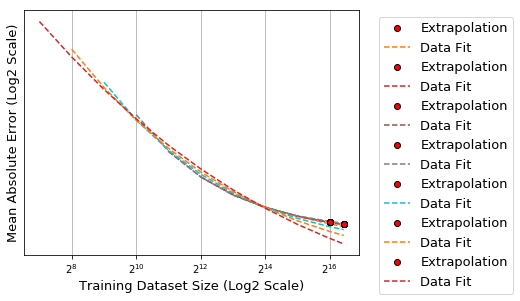

In [93]:
scr = scores_te.copy()
# scr = scores_te.copy().iloc[:-5, :]

# plot_args['figsize'] = (10, 8)
plot_args['figsize'] = (6, 4.5)

n_pnts_ext = 2 # Number of points to extrapolate to
n_pnts_fit = 6 # Number of points to use for curve fitting starting from the largest size

tot_pnts = len(scr['tr_size'])
m0 = tot_pnts - n_pnts_ext  # The adjusted number of available LC points
shard_min_idx = m0 - n_pnts_fit
# ---------------------------------------------


tot_pnts = len(scores_te['tr_size'])
print('tot_pnts', tot_pnts)
min_pnts_fit = 3 # 3 points doesn't work
# min_pnts_fit = 4
max_pnts_fit = 9
# max_pnts_fit = m0 # tot_pnts

p_arr = []
gof_arr = []
prm_arr = []
ax = None
for n_pnts_fit in range(min_pnts_fit, max_pnts_fit+1):
    shard_min_idx = m0 - n_pnts_fit
    
    # Extrapolation
    ax, _, gof = lrn_crv_plot.lrn_crv_power_law_extrapolate(
            x = scr['tr_size'][shard_min_idx:], y = scr['median'][shard_min_idx:],
            n_pnts_ext = n_pnts_ext,
            **plot_args, plot_raw_it=False, label_et='Extrapolation', ax=ax );    
    
    prm_arr.append(prm)
    gof_arr.append(gof)
    p_arr.append(n_pnts_fit)
    
# ax.legend(frameon=True, fontsize=10, loc='best');

# idx = np.array(rmse_arr).argmin()
# p_arr[idx]

In [94]:
prm_df = pd.DataFrame(prm_arr)
gof_df = pd.DataFrame(gof_arr)
n_pnts_df = pd.DataFrame({'n_pnts': p_arr})
dd = pd.concat([n_pnts_df, gof_df, prm_df], axis=1)

display(dd.sort_values('mae_et'))

,n_pnts,mae_et,mae_it,alpha,beta,gamma
2,5,0.000036,4.257231e-05,0.676031,-0.472859,0.066259
1,4,0.000055,4.268185e-05,0.676031,-0.472859,0.066259
3,6,0.000172,6.615266e-05,0.676031,-0.472859,0.066259
0,3,0.000354,4.625929e-18,0.676031,-0.472859,0.066259
4,7,0.000899,5.094281e-04,0.676031,-0.472859,0.066259
5,8,0.001851,7.984998e-04,0.676031,-0.472859,0.066259
6,9,0.003227,1.254222e-03,0.676031,-0.472859,0.066259


tot_pnts 17
GOF: {'mae_it': 0.0012542221829886836, 'mae_et': 0.0032272068655535904}
Fit MAE: {'mae_it': 6.615266230724827e-05, 'mae_et': 0.00017201111778082645}


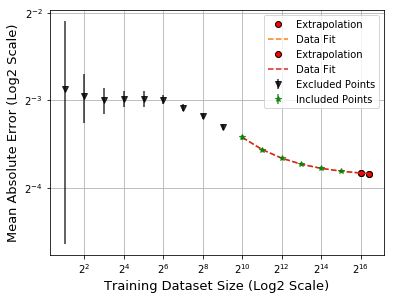

tot_pnts 17
GOF: {'mae_it': 0.0012542221829886836, 'mae_et': 0.0032272068655535904}
Fit MAE: {'mae_it': 4.257230622899122e-05, 'mae_et': 4.7986388737819574e-05}


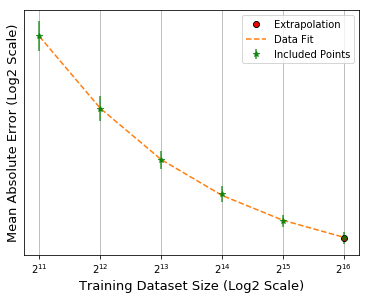

In [96]:
scr = scores_te.copy()
# scr = scores_te.copy().iloc[:-5, :]

# plot_args['figsize'] = (10, 8)
plot_args['figsize'] = (6, 4.5)

n_pnts_ext = 1 # Number of points to extrapolate to
n_pnts_fit = 6 # Number of points to use for curve fitting starting from the largest size

tot_pnts = len(scr['tr_size'])
m0 = tot_pnts - n_pnts_ext
shard_min_idx = m0 - n_pnts_fit
    
# p_et = 2 # Number of points to extrapolate to
# tot_pnts = len(scr['tr_size'])
# m0 = tot_pnts - p_et

print('tot_pnts', tot_pnts)
# min_points = 3 # 3 points doesn't work
# min_pnts = 4 # min points to use in the fit
# max_pnts = 9
# max_pnts = tot_pnts


# shard_min_idx = 0 if tot_pnts < n_pnts_fit else tot_pnts - n_pnts_fit


# n_pnts = 6 # Number of points to use for curve fitting
# shard_min_idx = tot_pnts - n_pnts
# shard_min_idx = m0 - n_pnts

ax = None

# Plot of all the points
# ax = lrn_crv_plot.plot_lrn_crv_new(
#         x=scr['tr_size'], y=scr['median'], yerr=scr['std'],
#         ax=ax, ls='', marker='v', alpha=0.8, color='k',
#         **plot_args, label='Excluded Points')

# Plot of all the points
ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scr['tr_size'][shard_min_idx:m0], y=scr['median'][shard_min_idx:m0], yerr=scr['std'][shard_min_idx:m0],
        ax=ax, ls='', marker='*', alpha=0.8, color='g',
        **plot_args, label='Included Points')

# Extrapolation
drop_pnts = 1 # Number of points to drop at the end
ax, _, mae_et = lrn_crv_plot.lrn_crv_power_law_extrapolate(
        # x=scr['tr_size'][shard_min_idx:], y=scr['median'][shard_min_idx:],
        x=scr['tr_size'][shard_min_idx:-drop_pnts], y=scr['median'][shard_min_idx:-drop_pnts],
        n_pnts_ext=n_pnts_ext,
        **plot_args, plot_raw_it=False, label_et='Extrapolation', ax=ax );

ax.legend(frameon=True, fontsize=10, loc='best')
# ax.set_xlim(min(scores_te['tr_size']), max(scores_te['tr_size'])+10000)
plt.savefig(save_fig_path/f'{src}_extrapolate.png')

print('GOF:', gof)
# print('RMSE:', rmse)
print('Fit MAE:', mae_et)

# Fig 4 When extrapolation doesn't work?

It's all about how you look at this. It's not an optical illusion.

# Fig 4a LC of GBDT and NN 

In [41]:
# lrn_crv_scores = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_cell/multi_seed_lgbm_100_trees/top6.lgb_reg.ge.dd.auc1_2019-12-2_h0-m23/lrn_crv_scores.csv'))
lrn_crv_scores = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_cell/nn_reg_ap/run_03/lrn_crv_scores.csv'))

In [42]:
get_xy(scores=lrn_crv_scores, shard_min_idx=0, cv_folds=1)

NameError: name 'get_xy' is not defined

In [43]:
lrn_crv_scores

,metric,tr_size,set,fold0
0,mean_absolute_error,128,tr,0.131119
1,mean_absolute_error,256,tr,0.074808
2,mean_absolute_error,512,tr,0.056520
3,mean_absolute_error,1024,tr,0.046221
4,mean_absolute_error,2048,tr,0.026125
5,mean_absolute_error,4096,tr,0.035211
6,mean_absolute_error,8192,tr,0.046258
7,mean_absolute_error,16384,tr,0.047926
8,mean_absolute_error,32768,tr,0.046330
9,mean_absolute_error,65536,tr,0.050888
